In [1]:
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 5,5 
rcParams['figure.figsize'] = 16, 10
import scipy, scipy.stats
import seaborn as sns
sns.set(color_codes=True, font_scale=1.2)

%config InlineBackend.figure_format = 'retina'


Let's load the distributions and plot the CDFs

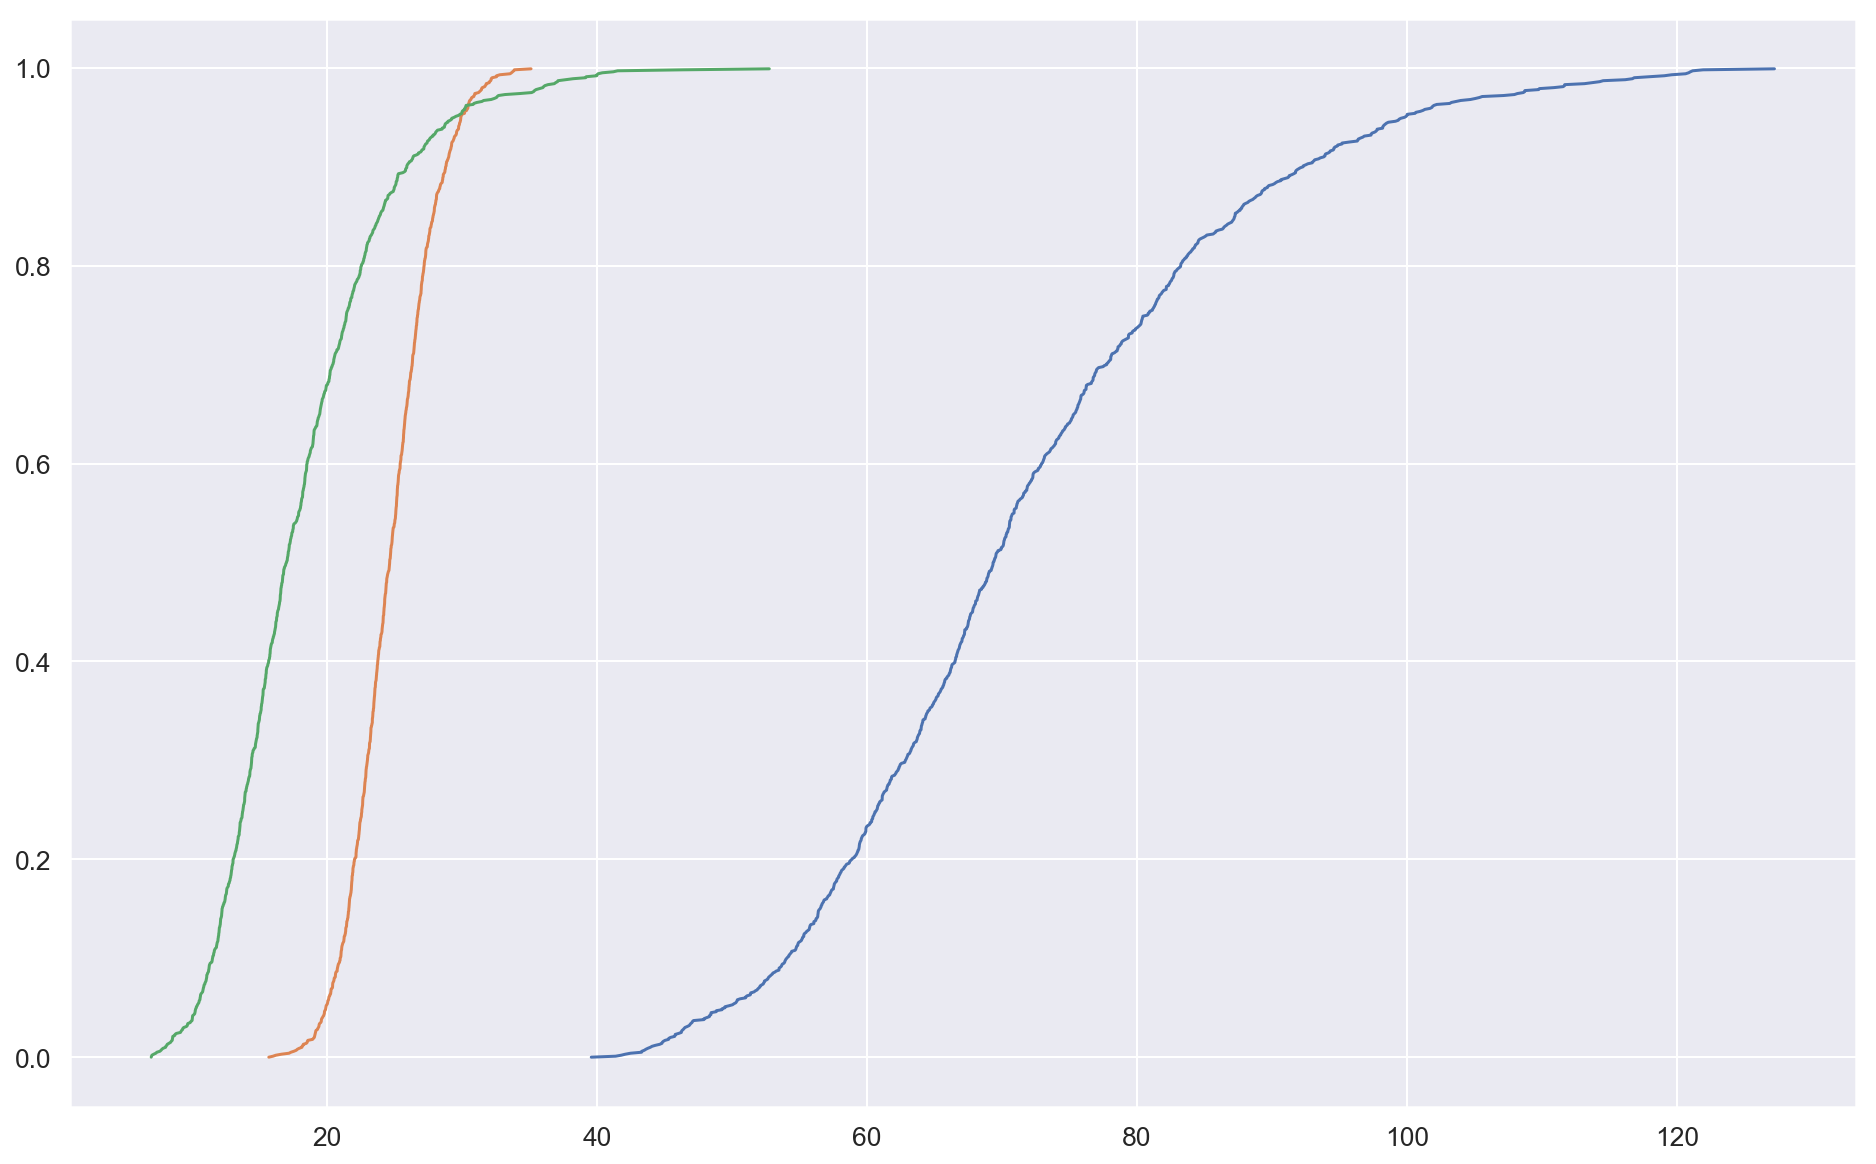

In [12]:
import json

with open('dist.json') as f:
    data = json.load(f)

for dist in data:
    xs, ys = dist['data']['xs'], dist['data']['ys']
    sns.lineplot(xs, ys)
    
    

Let's make a class CDF that will hold the spec in a vector pair (x, F), which is equivalent to xs and ys from the input.

The class method __combine__ will take a list of CDF objects and return a new CDF object holding the combined distribution. For now it just uses the same weights for each CDF.

The method __rvs__ returns a num




In [17]:
class CDF:
    def __init__(self, x, F):
        self.x = x
        self.F = F
    
    def combine(cdfs):
        x_unique = set()
        for cdf in cdfs:
            x_unique.update(cdf.x)

        x_combined = [t for t in sorted(x_unique)]

        weights = [1.0 / len(cdfs)] * len(cdfs)

        pos = [0] * len(cdfs)

        combined_cdf = {'x': [], 'F': []}

        for x in x_combined:
            weighted_F = 0
            for j in range(len(cdfs)):
                w = weights[j]
                x_j = cdfs[j].x
                F_j = cdfs[j].F
                p = pos[j]
                while p + 1 < len(x_j) and x_j[p+1] < x:
                    p += 1
                pos[j] = p

                if x < x_j[p]:
                    F = 0
                elif p == len(x_j) - 1:
                    F = F_j[p]
                else:
                    if x == x_j[p]:
                        F = F_j[p]
                    else:
                        y1 = F_j[p]
                        y2 = F_j[p + 1]
                        x2 = x_j[p + 1]
                        x1 = x_j[p]
        
                        k = (y2 - y1) / (x2 - x1)
                        y_interp = y1 + k * (x - x1)
                        F = y_interp

                weighted_F += w * F
            combined_cdf['x'].append(x)
            combined_cdf['F'].append(weighted_F)
        return CDF(x=combined_cdf['x'], F=combined_cdf['F'])
    
    def rvs(self, n):
        res = []
        for i in range(n):
            p = np.random.random()
            for x, F in zip(self.x, self.F):
                if F >= p:
                    res.append(x)
                    break
        if len(res) == 0:
            return self.x[-1]
        if n > 1:
            return np.array(res)
        else:
#             print('Returning ', res[0])
            return res[0]
                


In [5]:
cdfs = []
for dist in data:
    xs, ys = np.array(dist['data']['xs']), np.array(dist['data']['ys'])
    cdfs.append(CDF(x=xs, F=ys))

/Users/drazenz/virtualenvs/jupyter/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


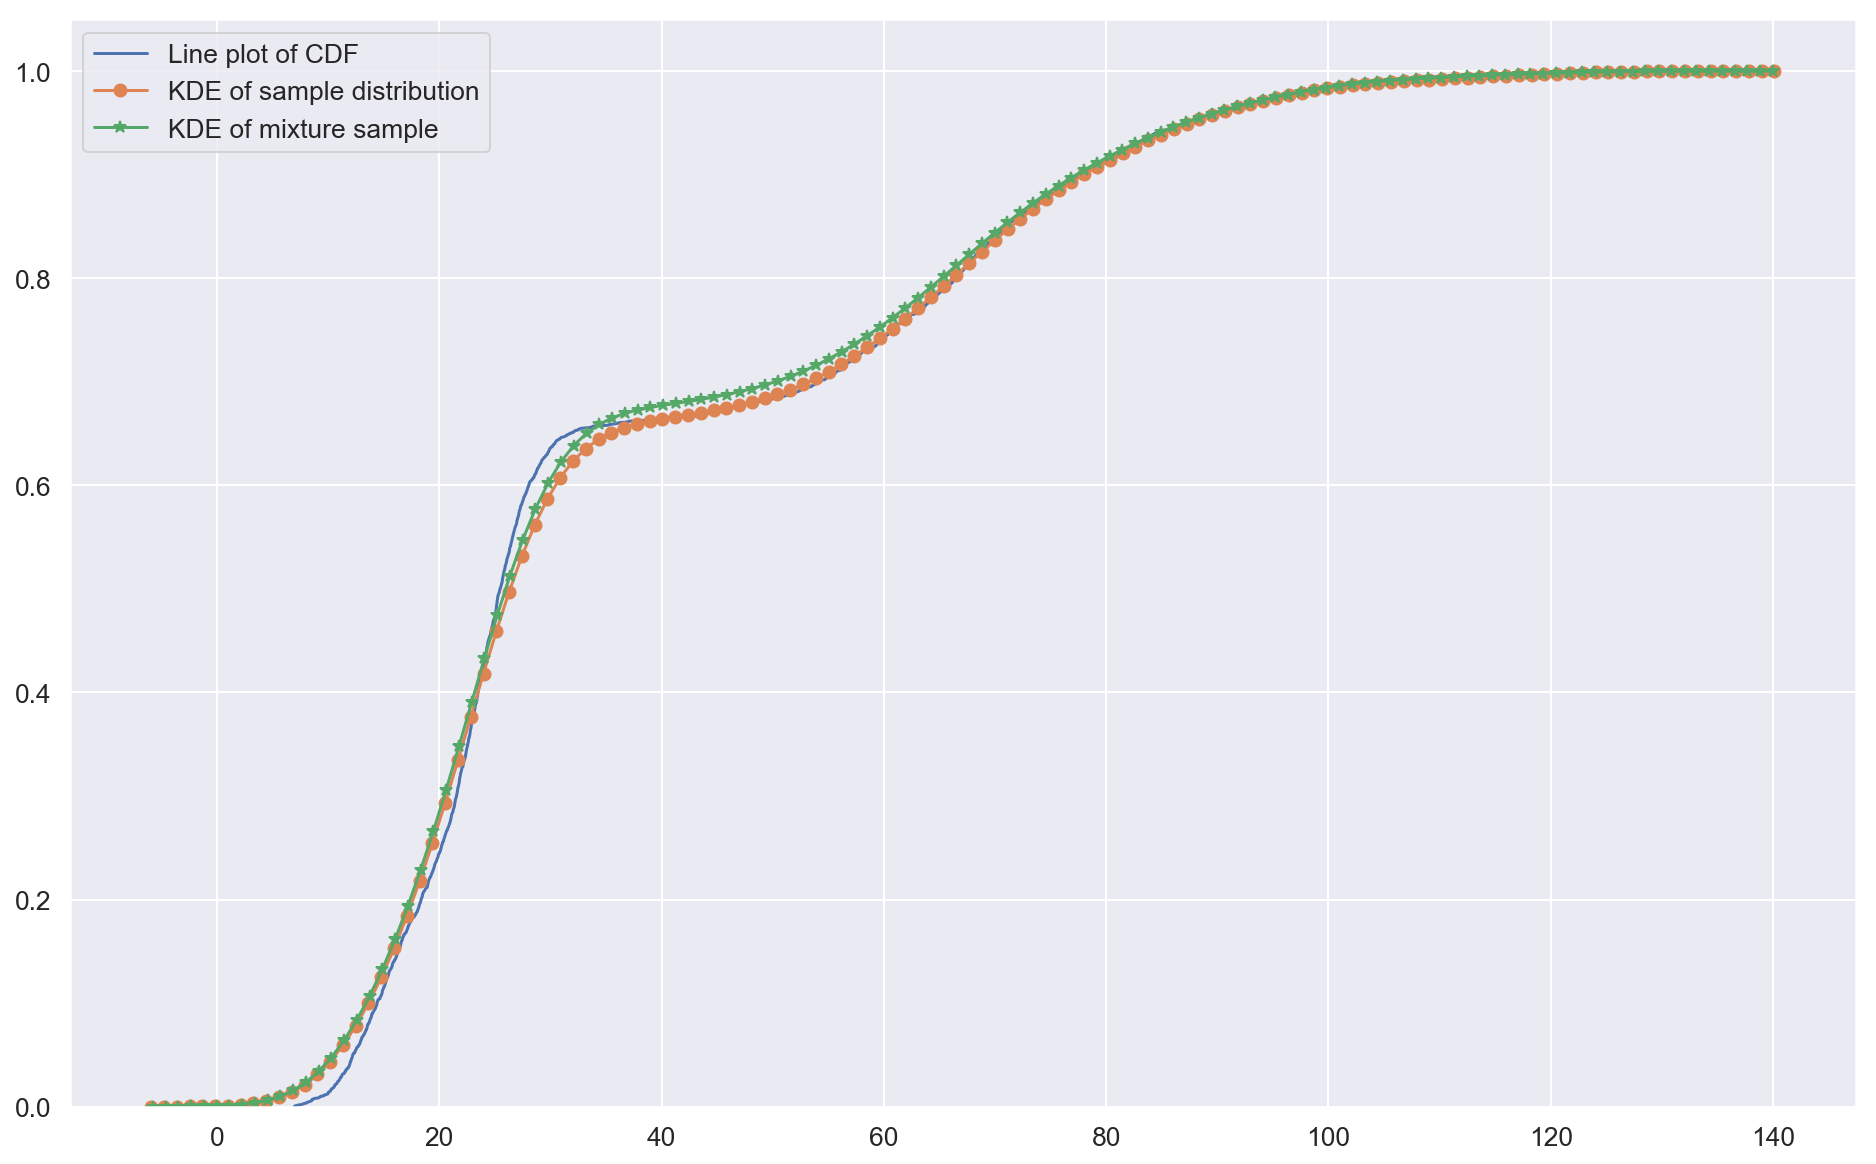

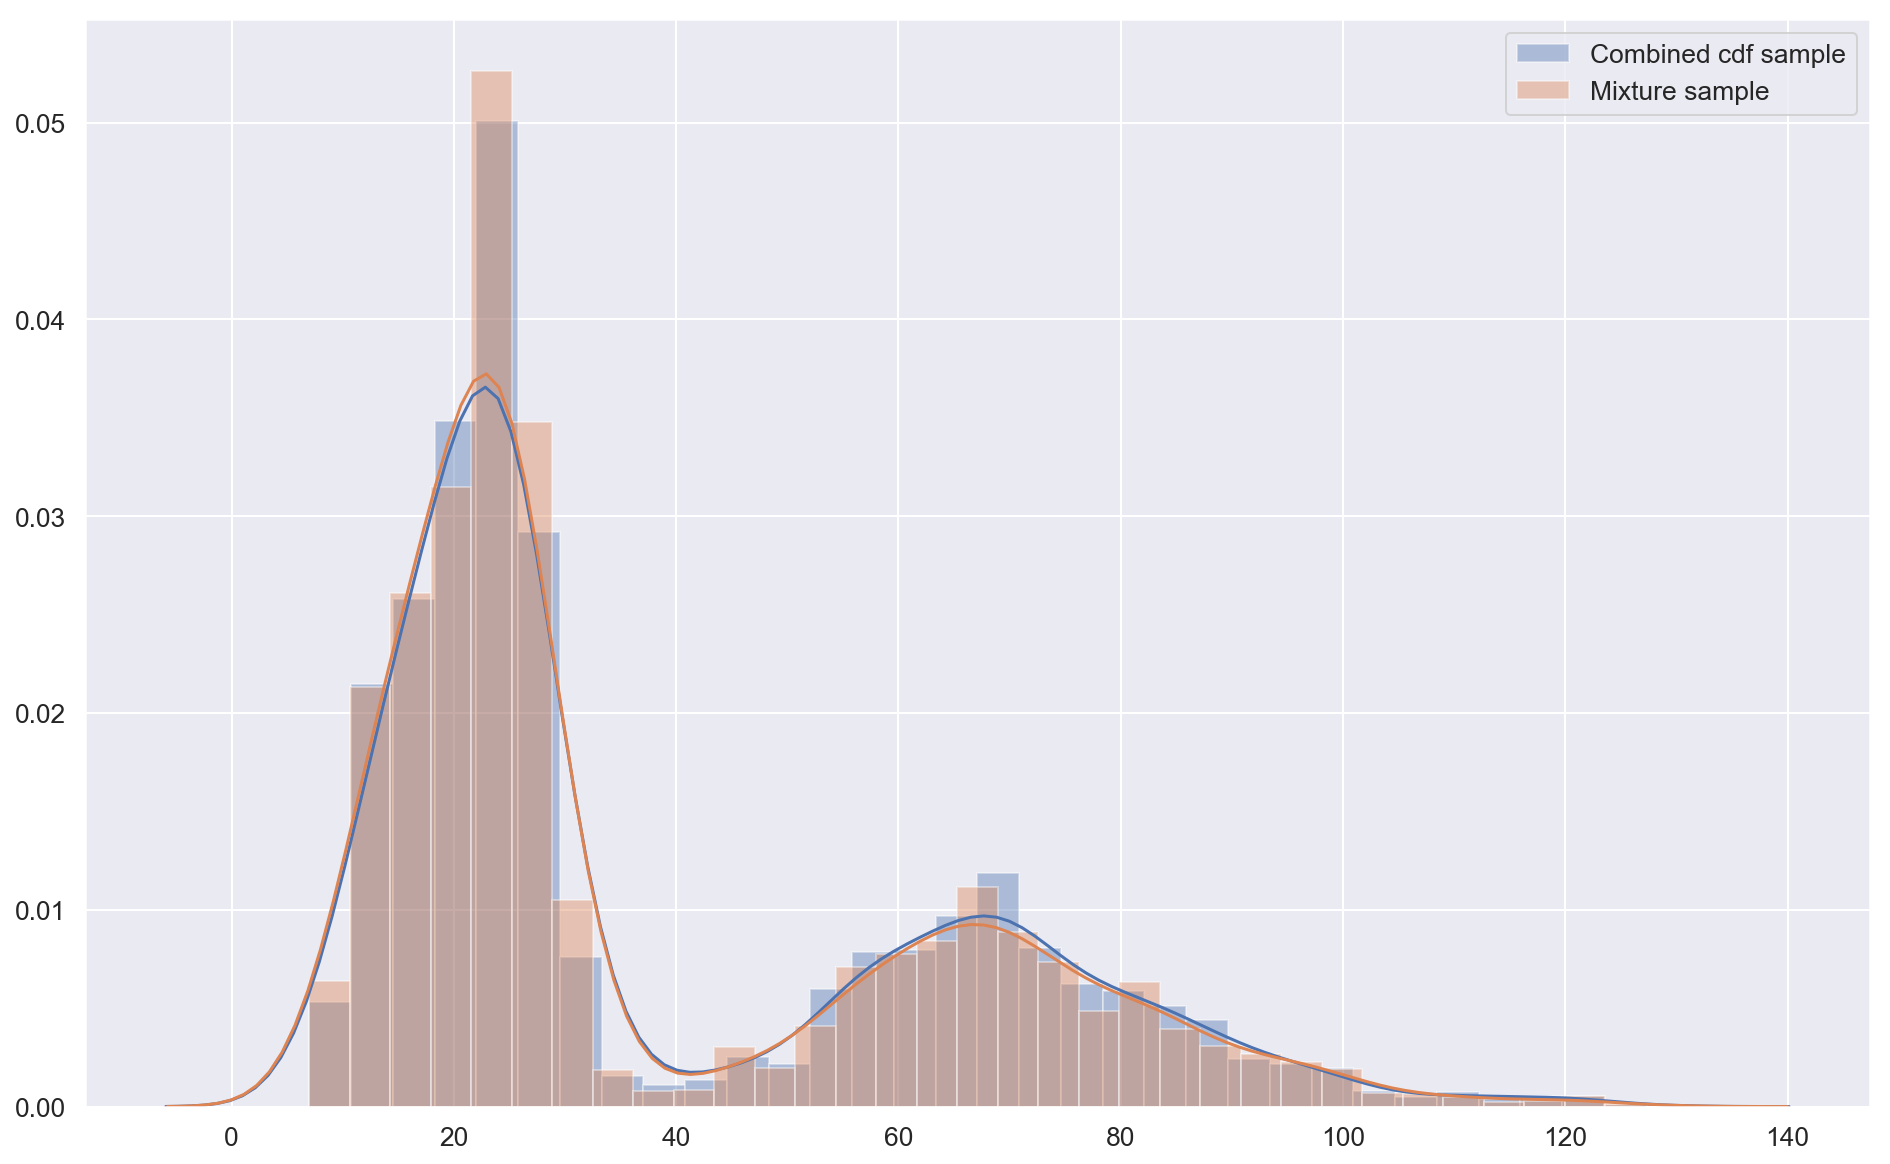

In [10]:
# Let's check the plot of CDF and make some samples from it using the rvs method
combined = CDF.combine(cdfs)
plt.plot(combined.x, combined.F, label='Line plot of CDF')

combined_cdf_sample = combined.rvs(10000)
sns.kdeplot(combined_cdf_sample, cumulative=True, label='KDE of sample distribution', marker='o')


# Now let's simulate sampling from a mixture and see what we get
def mixture_rvs(cdfs, weights, n):
    weights = np.array(weights)
    weights = weights / np.sum(weights) # make sure weights are normalized
    
    res = []
    for i in range(n):
        # choose distribution from which to sample
        p = np.random.random()
        c_sum = 0
        
        for ind, w in enumerate(weights):
            c_sum += w
            if c_sum >= p:
                selected_cdf = cdfs[ind]
                break
        r = selected_cdf.rvs(n=1)
        res.append(r)
    
    return np.array(res)

mixture_sample = mixture_rvs(cdfs, [1.0/len(cdfs)]*len(cdfs), 10000)
sns.kdeplot(mixture_sample, cumulative=True, label='KDE of mixture sample', marker='*')
plt.legend()
plt.figure()
sns.distplot(combined_cdf_sample, label='Combined cdf sample')
sns.distplot(mixture_sample, label='Mixture sample')
plt.legend()

